# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1ANUjFD-iRBZuo1i15vgYmknoheh0rtkN'

In [2]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


1ANUjFD-iRBZuo1i15vgYmknoheh0rtkN


In [3]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')
#df = pd.read_csv('Reviews.csv')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:42<00:00, 2234.86it/s]


In [26]:
preprocessed_reviews[3500]

'tried teas yet nice really love variety able try something new'

In [0]:
final['cleanedText']=preprocessed_reviews

In [0]:
 con1 = sqlite3.connect('revised.sqlite')
 c=con1.cursor()
 con1.text_factory = str
 final.to_sql('Reviews', con1,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
 con1.close()

In [0]:
if os.path.isfile('revised.sqlite'):
    conn = sqlite3.connect('revised.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [28]:
final.shape

(364171, 11)

# **Assignment 4: Apply Naive Bayes**
****

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

## [4.1] BAG OF WORDS

In [33]:
#Taking random 80000 ponits

final_data = final.sample(n=80000)

final_data.shape

(80000, 11)

In [34]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final = final_data.sort_values(by = "Time")
print(final.shape)
final.head(5)

(80000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...
417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,2001-06-11,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,michael keaton brings no distinguishing charac...
443669,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,1,2002-05-23,Way To Go Guys!,I'm never dissapointed with the great gadgets ...,never dissapointed great gadgets company comes...


In [35]:
# 80k data which will use to train model 
X = final['cleanedText']
print("shape of X:", X.shape)
# class label
y = final["Score"]
print("shape of y:", y.shape)

shape of X: (80000,)
shape of y: (80000,)


In [92]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 52)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print(X_train.shape, y_train.shape, x_test.shape)

(56000,) (56000,) (24000,)


In [37]:
# Training to Bow Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_trainb = bow.fit_transform(X_train)
X_trainb


<56000x45683 sparse matrix of type '<class 'numpy.int64'>'
	with 1837100 stored elements in Compressed Sparse Row format>

In [38]:
X_trainb.shape

(56000, 45683)

In [39]:
# Test Vectorizor training
x_testb = bow.transform(x_test)
x_testb.shape

(24000, 45683)

In [94]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import brier_score_loss
nb = MultinomialNB()
nb.fit(X_trainb, y_train)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
#clf = CalibratedClassifierCV(nb, parameters, cv=5, scoring='roc_auc')
clf_sigmoid = CalibratedClassifierCV(nb , cv=5, method='sigmoid')
clf_sigmoid.fit(X_trainb, y_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(x_testb)[:, 1]





#clf = CalibratedClassifierCV(nb, cv=2, method='sigmoid')
#clf.fit(X_trainb, y_train)
print(clf_sigmoid.predict_proba(X_trainb[:1]))
# this code source here: https://stackoverflow.com/a/48803361/4084039
#print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf_sigmoid.get_params)
#print("Accuracy: %.2f%%"%(clf.best_score_*100))




[[0.05966599 0.94033401]]
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
            cv=5, method='sigmoid')>


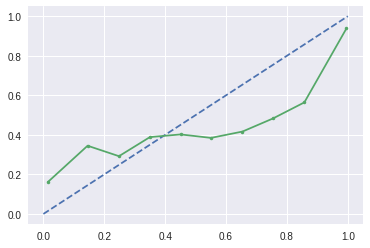

In [96]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
prob = clf_sigmoid.predict_proba(x_testb)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, prob, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [42]:
clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

With sigmoid calibration: 0.079


In [0]:
#Source https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361
#plt.semilogx(alpha, clf.cv_results_['mean_train_score'], label='Train')
#plt.semilogx(alpha, clf.cv_results_['mean_test_score'], label='Test')
#plt.legend()

In [0]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

nbm = MultinomialNB(alpha=0.05)
nbm.fit(X_trainb,y_train)
y_true, y_pred = y_test, nbm.predict(x_testb)
#y_pred = nbm.predict(x_test)

In [44]:
### Used code from https://blancas.io/sklearn-evaluation/api/plot.html
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      3809
           1       0.94      0.95      0.94     20191

   micro avg       0.90      0.90      0.90     24000
   macro avg       0.82      0.80      0.81     24000
weighted avg       0.90      0.90      0.90     24000



In [0]:
bow_features = bow.get_feature_names()

In [46]:
#Calculating log prob
log_prob = nb.feature_log_prob_
log_prob

array([[-12.25720768, -12.95035486, -12.95035486, ..., -12.95035486,
        -12.95035486, -12.95035486],
       [-12.03513819, -12.64127399, -13.0467391 , ..., -13.33442117,
        -13.73988628, -13.73988628]])

In [47]:
#Empiricalvalues
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(45683, 2)

In [48]:
#Top positive values from Git search
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 not       -3.750703
like      -4.587122
good      -4.702353
great     -4.775383
one       -4.930845
taste     -4.988649
product   -5.088512
coffee    -5.092016
would     -5.110526
flavor    -5.111957
Name: 1, dtype: float64


In [49]:
#Top negavtive values from Git search
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -3.375024
like      -4.506378
product   -4.725655
would     -4.764447
taste     -4.784423
one       -4.999852
good      -5.209690
no        -5.227235
flavor    -5.270641
coffee    -5.326224
Name: 0, dtype: float64


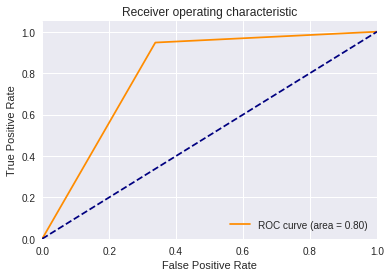

In [50]:
#Plotting AUC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred )
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 2522,  1287],
       [ 1056, 19135]])

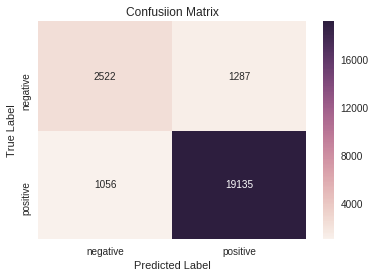

In [52]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Applying Multinomial Naive Bayes

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation


In [53]:
#tfidf vectoriser
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_traintf = tf_idf_vect.fit_transform(X_train)
X_traintf

<56000x1024851 sparse matrix of type '<class 'numpy.float64'>'
	with 3924079 stored elements in Compressed Sparse Row format>

In [86]:
# Convert test text data to its vectorizor
x_testtf = tf_idf_vect.transform(x_test)
x_testtf.shape

(24000, 1024851)

In [98]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import brier_score_loss
nbtf = MultinomialNB()
nbtf.fit(X_trainb, y_train)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
#clf = CalibratedClassifierCV(nb, parameters, cv=5, scoring='roc_auc')
clf_sigm = CalibratedClassifierCV(nbtf , cv=5, method='sigmoid')
clf_sigm.fit(X_traintf, y_train)
prob_pos_sigm = clf_sigm.predict_proba(x_testtf)[2:, 1]





#clf = CalibratedClassifierCV(nb, cv=2, method='sigmoid')
#clf.fit(X_trainb, y_train)
print(clf_sigmoid.predict_proba(X_trainb[:1]))
print(prob_pos_sigm)
# this code source here: https://stackoverflow.com/a/48803361/4084039
#print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf_sigmoid.get_params)
#print("Accuracy: %.2f%%"%(clf.best_score_*100))




[[0.05966599 0.94033401]]
[0.90347443 0.89399655 0.68772501 ... 0.88969834 0.90160709 0.90561277]
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
            cv=5, method='sigmoid')>


In [57]:
##Training the model with cv=5 with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
nbtf = MultinomialNB()
nbtf.fit(X_traintf, y_train)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
clf1 = GridSearchCV(nbtf, parameters, cv=5, scoring='roc_auc')
clf1.fit(X_traintf, y_train)
print(nbtf.predict(X_traintf[2:3]))

# this code source here: https://stackoverflow.com/a/48803361/4084039
print("Best cross-validation score: {:.2f}".format(clf1.best_score_))
print("Best parameters: ", clf1.best_params_)
print("Accuracy: %.2f%%"%(clf1.best_score_*100))##


[1]
Best cross-validation score: 0.91
Best parameters:  {'alpha': 0.1}
Accuracy: 91.02%


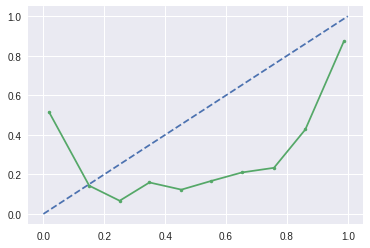

In [82]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = clf_sigm.predict_proba(x_testtf)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [0]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

nbm = MultinomialNB(alpha=0.05)
nbm.fit(X_traintf,y_train)
y_truetf, y_predtf = y_test, nbm.predict(x_testtf)
#y_pred = nbm.predict(x_test)

In [62]:
### Used code from https://blancas.io/sklearn-evaluation/api/plot.html
from sklearn.metrics import classification_report
print(classification_report(y_truetf, y_predtf))

              precision    recall  f1-score   support

           0       0.95      0.22      0.36      3809
           1       0.87      1.00      0.93     20191

   micro avg       0.87      0.87      0.87     24000
   macro avg       0.91      0.61      0.64     24000
weighted avg       0.88      0.87      0.84     24000



In [63]:
#Feature count
tfidf_features = tf_idf_vect.get_feature_names()
feat_count = nbtf.feature_count_
feat_count.shape



(2, 1024851)

In [64]:
#Getting log probability
log_prob = nbtf.feature_log_prob_
log_prob


array([[-13.10060978, -14.67137919, -14.67137919, ..., -14.67137919,
        -14.67137919, -14.67137919],
       [-12.40622466, -14.63306484, -14.33240609, ..., -14.5460911 ,
        -14.54281682, -14.54281682]])

In [65]:
#Getting empirircal values
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tf = feature_prob.T
feature_prob_tf.shape

(1024851, 2)

In [66]:
#Top positive features
print("\n\n Top 10 positive features:-\n",feature_prob_tf[1].sort_values(ascending = False)[0:10])



 Top 10 positive features:-
 not       -6.057264
great     -6.398174
good      -6.464310
like      -6.522536
coffee    -6.573230
tea       -6.599386
love      -6.645471
product   -6.736689
taste     -6.752507
one       -6.781564
Name: 1, dtype: float64


In [67]:
#Top negative features from Git search
print("Top 10 negative features:-\n",feature_prob_tf[0].sort_values(ascending = False)[0:10])

Top 10 negative features:-
 not       -5.938560
like      -6.763186
product   -6.833102
taste     -6.863287
would     -6.882868
coffee    -7.168792
one       -7.195135
no        -7.270690
flavor    -7.291524
good      -7.405415
Name: 0, dtype: float64


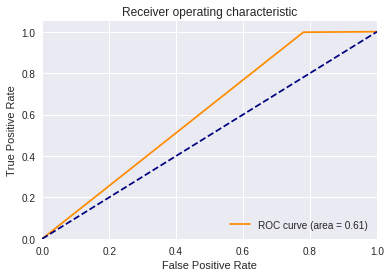

In [68]:
#plotting AUC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_predtf )
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [69]:
#from sklearn.matrics import confusion_matrix
cmt = confusion_matrix(y_test, y_predtf)
cmt

array([[  838,  2971],
       [   48, 20143]])

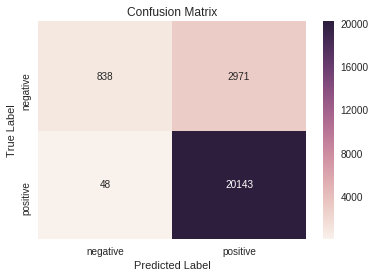

In [70]:
#Plotting confusion matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cmt, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [99]:
#pretty table

from prettytable import PrettyTable
    
p = PrettyTable()

p.field_names = ["Vectoriser model", "Hyperparameter", "AUC", ]

p.add_row(["BOW", 0.39, 0.80,] )
p.add_row(["TFIDF", 0.18, 0.61,])
print(p)

+------------------+----------------+------+
| Vectoriser model | Hyperparameter | AUC  |
+------------------+----------------+------+
|       BOW        |      0.39      | 0.8  |
|      TFIDF       |      0.18      | 0.61 |
+------------------+----------------+------+
